In [ ]:
# imports
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd

**1. Correctly implement and submit your own code for the perceptron learning algorithm.**

In [ ]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.shuffle = shuffle
        self.epochs_count = 0
        self.missclassifications = []

    def fit(self, X, y, initial_weights=None, weights_given = False, Deterministic=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # Allow the model to train for a maximum of 100 epochs if deterministic ephoc number is not given
        set_num_epochs = True
        if Deterministic == None:
          set_num_epochs = False
          Deterministic = 100
          best_accuracy_so_far = 0
          epochs_w_o_improvement = 0
          # Divide the data into training (70%) and test (30%) sets
          X, y, self.test_data, self.test_targets = self.training_test_split(X, y)


        # Append bias weights to training data rows
        X_biased = np.append(X, np.ones((np.shape(X)[0], 1)), 1)
        self.training_data, self.training_targets = X_biased, y

        # Initialize weights if not provided
        if weights_given == False:
          self.weights = self.initialize_weights()
        else:
          self.weights = initial_weights
        
        for epoch in range(Deterministic):
          # Keep track of previous weights to revert back to if there is no improvement for the next 5 epochs
          epoch_starting_weights = self.weights.copy()

          # Shuffle data if required, each epoch
          if self.shuffle:
            self.training_data, self.training_targets = self._shuffle_data(X_biased, y)

          # Train model on data, row by row, updating weight vector according by stochastic gradient descent ( Delta-W_i = lr * (target - output) * W_i)
          i = 0
          length = np.shape(self.training_data)[0]
          while i < length:
            net = np.dot(self.training_data[i], self.weights)
            Output = 0 if net <= 0 else 1
            Delta_W_i = np.array([self.lr * (self.training_targets[i] - Output) * x for x in self.training_data[i]]).reshape(-1,1)
            self.weights = self.weights + Delta_W_i
            i += 1

          # Stopping Criteria: if no improvement in accuracy is recorded for 5 consecutive epochs, revert to weights from 5 epochs ago, halt training
          if set_num_epochs == False:
            accuracy = float(self.score(self.test_data, self.test_targets))
            if accuracy <= best_accuracy_so_far:
              epochs_w_o_improvement += 1
              if epochs_w_o_improvement == 1:
                reverted_weights = epoch_starting_weights
            else:
              epochs_w_o_improvement = 0
              best_accuracy_so_far = accuracy

          self.epochs_count += 1
          if set_num_epochs == False and epochs_w_o_improvement == 5:
            self.weights = reverted_weights
            break
          
        if set_num_epochs == False:
          # Remove bias weights from training data for final training accuracy scoring, and bias weights are always added to datasets in the score() function
          self.best_training_accuracy = float(self.score(self.training_data[:,:-1], self.training_targets))
          self.best_test_accuracy = best_accuracy_so_far

        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        return np.array( [(0 if np.dot(X[i,:], self.weights) <= 0 else 1) for i in range(np.shape(X)[0])] )

    # Creates weight vector with random values between -1 inclusive and 1 inclusive
    def initialize_weights(self):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        min_val, max_val = -1, 1
        range_size = max_val - min_val
        return (np.random.rand(np.shape(self.training_data)[1], 1) * range_size + min_val).reshape(-1,1)
        #return (np.random.rand(1, np.shape(self.training_data)[1]) * range_size + min_val).reshape(1,-1)

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        # Append bias weights to training data rows
        X = np.append(X, np.ones((np.shape(X)[0], 1)), 1)
        self.training_data, self.training_targets = X, y

        predictions = self.predict(X)
        
        accuracy = np.mean([1 if predictions[i] == y[i] else 0 for i in range(0, np.shape(y)[0])])
        # Keep track of misclassification counts and total number of data points in a tuple 
        self.missclassifications.append(1.0 - accuracy)
        return "{:.2f}".format( accuracy )

    def training_test_split(self, X, y):
      X_shuffled, y_shuffled = self._shuffle_data(X, y)
      y_shuffled = y_shuffled.reshape(-1,1)

      composite = np.concatenate((X_shuffled, y_shuffled), 1)
      rowC = np.shape(composite)[0]
      splitPos = int(0.7 * rowC)
      training = composite[:splitPos, :]
      test = composite[splitPos:, :]
      
      return training[:, :-1], training[:,-1].reshape(-1,1), test[:, :-1], test[:,-1].reshape(-1,1)

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        composite = np.concatenate((X, y), 1)
        rowC = np.shape(composite)[0]
        shuffled = np.zeros(np.shape(composite))
        for i in range(0, rowC):
          rand = np.random.randint(np.shape(composite)[0])
          shuffled[i][:] = composite[rand][:]
          composite = np.delete(composite, rand, 0)
        return shuffled[:,:-1], shuffled[:,-1]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def get_epochs_count(self):
      return self.epochs_count

    def get_training_accuracy(self):
      return self.best_training_accuracy

    def get_test_accuracy(self):
      return self.best_test_accuracy

    def get_missclassifications(self):
      return self.missclassifications

**1.1 Debug and Evaluation**

Use your perceptron code first to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident your code is correct, run your perceptron on the Evaluation data with the same parameters.

Debug and Evaluate your model using the parameters below

Learning Rate = 0.1 \ Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it] \ Shuffle = False \ Initial Weights = All zeros

**1.1.1 (20%) Debug**

Debug your model by running it on the debug dataset

Expected Results:

Accuracy = [0.88]\ Final Weights = [-0.23 0.18 -0.1 ]

In [ ]:
# Load debug data
!curl -o debug_data.arff https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff
debug_data = np.array(arff.loadarff('debug_data.arff')[0].tolist(), dtype=np.double)
X, y = debug_data[:,:-1], debug_data[:,-1].reshape(-1,1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   2525      0 --:--:-- --:--:-- --:--:--  2525


In [ ]:
# Train on debug data
p = PerceptronClassifier(lr = 0.1, shuffle = False)
_ = p.fit(X, y, initial_weights = np.zeros((np.shape(X)[1]+1, 1)), weights_given=True, Deterministic=10)

# Have your code print your accuracy and weights
print("Accuracy: [",p.score(X, y),"]")
print("Final Weights:",np.transpose(p.get_weights()))

Accuracy: [ 0.88 ]
Final Weights: [[-0.23  0.18 -0.1 ]]


Discussion:
I created a perceptron that randomly sorts the rows of a dataset (unless specified otherwise), and creates an initial weight vector of random values between -1 and 1 (unless specified otherwise). The perceptron reads in data from a .arff file, divides into training and test sets by a 70-30 random split, separates the training target column from the rest of the training data (unless specified otherwise, and trains based on those sets of training data. Unless given a specified number of epochs to run for, the perceptron continues to train on the dataset until there is no improvement of accuracy on the test set for 5 consecutive epochs, or for a maximum of 100 epochs.

**1.1.2 (20%) Evaluation**

We will evaluate your model based on it's performance on the evaluation dataset. Use the same parameters as the debug dataset

In [ ]:
# Load evaluation data
!curl -o eval_data.arff https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff
eval_data = np.array(arff.loadarff('eval_data.arff')[0].tolist(), dtype=np.double)
X, y = eval_data[:,:-1], eval_data[:,-1].reshape(-1,1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   670k      0 --:--:-- --:--:-- --:--:--  680k


In [ ]:
# Train on evaluation data
p = PerceptronClassifier(lr = 0.1, shuffle = False)
_ = p.fit(X, y, np.zeros((np.shape(X)[1]+1, 1)), weights_given=True, Deterministic=10)

# Have your code print your accuracy and weights
print("Accuracy: [",p.score(X, y),"]")
print("Final Weights:",np.transpose(p.get_weights()))

Accuracy: [ 0.99 ]
Final Weights: [[-3.80657242 -2.840821   -3.0719334  -1.4003906   4.9       ]]


Discussion:

The evaluation dataset was trained on using the same parameters that were used for training on the debug dataset. There appears to be a highly negative correlation between the output and the first and third inputs, while a slightly milder, negative correlation appears to exist between the second and fourth inputs. I am not sure what a final bias weight of 4.9 signifies on a dataset of this dimensionality, but it may simply signify that the threshold for classification is a high one. The perceptron reported an accuracy of 99% after training for 10 epochs.

**2. Classifying on linearly separable and non-linearly separable data**

**2.1 (5%) Create 2 datasets**

Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class.
One data set should be linearly separable and the other not.

In [ ]:
# Create 2 datasets
seperable = np.array([[0.55, 0.8, 1],
                      [0.7, 0.9, 1],
                      [0.48, 0.7, 1],
                      [0.98, 0.85, 1],
                      [-0.4, -0.75, 0],
                      [-0.9, -0.8, 0],
                      [-0.65, -0.1, 0],
                      [-0.725, -0.96, 0]])

inseperable = np.array([[0.99, -0.2, 1],
                      [-0.5, 0.65, 1],
                      [0, -0.7, 0],
                      [0.1, -0.9, 0],
                      [-0.75, -0.9, 1],
                      [0.65, -0.4, 1],
                      [-0.2, 0.8, 0],
                      [0.3, -0.2, 0]])

Discussion:

The seperable dataset should be easily learnable, as any value with a high x_1 value and high x_2 value will have a classification of 1. A value with a low x_1 value and low x_2 value will have a classification of 0.
The insperable dataset has a very random distribution, with no uniform correlation between inputs and output.


**2.2 (5%) Train on both sets with your perceptron code (with LR=.1)**

In [ ]:
# Train on each dataset

# Seperable dataset training
X_seperable, y_seperable = seperable[:, :-1], seperable[:, -1].reshape(-1,1)
p_seperable = PerceptronClassifier(lr = 0.1, shuffle = True)
_ = p_seperable.fit(X_seperable, y_seperable)
w_s = p_seperable.get_weights()

# Inseperable dataset training
X_inseperable, y_inseperable = inseperable[:, :-1], inseperable[:, -1].reshape(-1,1)
p_inseperable = PerceptronClassifier(lr = 0.1, shuffle = True)
_ = p_inseperable.fit(X_inseperable, y_inseperable)
w_i = p_inseperable.get_weights()

Discussion:

**2.3 (5%) Graph the datasets and their corresponding decision line**

Graph each dataset
Use your trained perceptrons above to determine each dataset's decision line
For all graphs always label the axes!

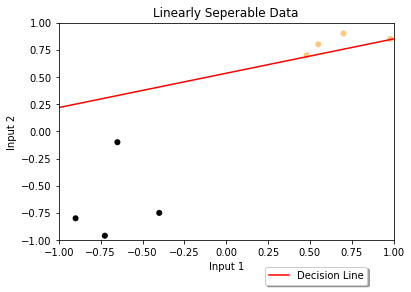

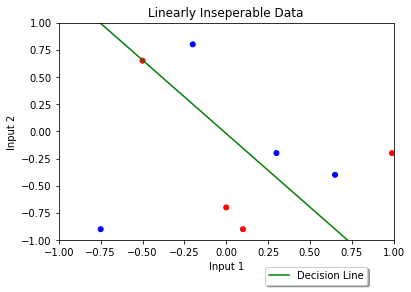

In [ ]:
# Graph datasets and decision lines

# Linearly Seperable Data
line_x_s = [0.25 * i for i in range(-4, 5)]
line_y_s = [(w_s[2] - w_s[0] * 0.25 * i)/w_s[1] for i in range(-4, 5)]
plt.scatter(X_seperable[:, 0], X_seperable[:, 1], s=25, c=y_seperable, cmap = 'copper')
line, = plt.plot(line_x_s, line_y_s, 'r-')
line.set_label('Decision Line')
plt.legend(loc='upper left', bbox_to_anchor=(0.6, -0.1),
          ncol=1, fancybox=True, shadow=True)
plt.title('Linearly Seperable Data')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.axis([-1,1,-1,1])
plt.show()

# Linearly Inseperable Data
line_x_is = [0.25 * i for i in range(-4, 5)]
line_y_is = [(w_i[2] - w_i[0] * 0.25 * i)/w_i[1] for i in range(-4, 5)]
plt.scatter(X_inseperable[:, 0], X_inseperable[:, 1], s=25, c=y_seperable, cmap = 'bwr')
line, = plt.plot(line_x_is, line_y_is, 'g-')
line.set_label('Decision Line')
plt.legend(loc='upper left', bbox_to_anchor=(0.6, -0.1),
          ncol=1, fancybox=True, shadow=True)
plt.title('Linearly Inseperable Data')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.axis([-1,1,-1,1])
plt.show()

Discussion:

**2.4 (5%) Discuss why the perceptron won’t converge on non-linearly separable data.**

Discussion: 

The perceptron will not converge on non-linearly separable data because the weight vector will constantly move in different directions, with no consistency. Incremental updates to the weight vector will offset changes made to it in past iterations, making prospective weight changes infinite with no predicted improvement in accuracy.

**3. Use your perceptron code to learn this version of the voting data set.**

This particular task is an edited version of the standard voting set, where we have replaced all the “don’t know” values with the most common value for the particular attribute.

**3.1 (10%) Create a table that reports the final training and test set accuracy and the number of epochs for each trial.**


Try it five times with different random 70/30 splits.
Use your own code to randomize and make splits.
Report the 5 trials and the average across the 5 trials in a table (below is an example of what a smaller table might look like).
As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.

In [ ]:
!curl -o voting_data.arff https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting-dataset.arff
voting_data = arff.loadarff('voting_data.arff')
voting_df = pd.DataFrame(voting_data[0])
voting_label_encoded_df = voting_df.apply(LabelEncoder().fit_transform)
npa = np.array(voting_label_encoded_df)
X_voting, y_voting = npa[:,:-1], npa[:,-1].reshape(-1,1)

# 0 = yes, 1 = yes
# 0 = Democrat, 1 = Republican

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43825  100 43825    0     0   350k      0 --:--:-- --:--:-- --:--:--  350k


In [ ]:
# Create the table any way you like

results = pd.DataFrame(columns=['Trial', 'Training Accuracy', 'Test Accuracy', 'Number of Epochs'])
weights = np.zeros((5, 17))
misclassifications = []

for i in range(1, 6):
  p_voting = PerceptronClassifier()
  _ = p_voting.fit(X_voting, y_voting)
  weights[i-1] = p_voting.get_weights().reshape(1,-1)
  misclassifications.append(p_voting.get_missclassifications())
  results.loc[len(results.index)] = [i, p_voting.get_training_accuracy(), p_voting.get_test_accuracy(), int(p_voting.get_epochs_count())]

results.loc[len(results.index)] = ['Average', results['Training Accuracy'].mean(), results['Test Accuracy'].mean(), results['Number of Epochs'].mean()]
#misclassification_data 
#print(misclassifications)
mcDf = pd.DataFrame(misclassifications)
avg_misclassification_rates = np.mean(mcDf, 0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    columnwidth = [50, 50, 50, 50],
    header=dict(values=list(results.columns),
                 fill_color='royalblue',
                align='left',
                line_color='gray',
                font=dict(color='white', size=12),),
    cells=dict(values=[results['Trial'], results['Training Accuracy'], results['Test Accuracy'], results['Number of Epochs']],
                fill_color=[['lightgray','white','lightgray', 'white','lightgray','white']*4],
                align='left',
                line_color='gray',
                font=dict(color='black', size=12)))
    ])

fig.show()

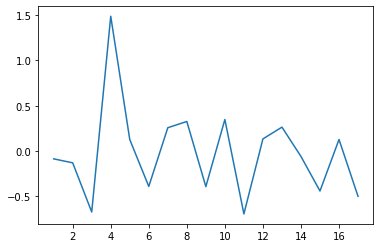

In [ ]:
a = np.arange(1,18)
plt.plot(a,np.mean(weights,0))
plt.show()

Discussion:

**3.2 (5%) By looking at the weights, do your best to explain what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical?**

Explanation:

The model has learned that 'yes' answers to questions 3 (water-project-cost-sharing), 9 (aid-to-nicaraguan-contras), 11 (immigration) and 17 (export-administration-act-south-africa) are the best predictors of a democratic voter. On the other hand, it has learned that 'yes' answers to questions 4 (adoption-of-the-budget-resolution), 5 (physician-fee-freeze), 7 (religious-groups-in-schools), 8 (anti-satellite-test-ban) and 10 (mx-missile) are the best predictors for a republican voter. Features less critical to the voting task include questions 1, 2, 6, 12, 13, 14 and 16. 

**3.3 (5%) Make a graph of the average misclassification rate vs epochs (0th – final epoch).**

Average the misclassification rate for the training set across your 5 trials (not across 5 epochs): mean(number misclassified / number of total data points) vs epoch
For larger number epochs, only include in the average those runs that trained for at least that length

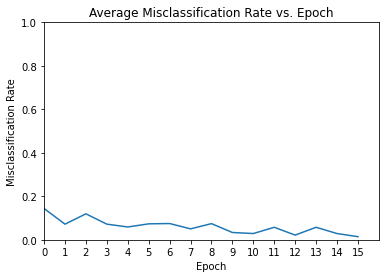

In [ ]:
# Graph here
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.axis([0,len(avg_misclassification_rate),0,1])
    plt.xticks(np.arange(0, len(avg_misclassification_rate)))
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()

plot_misclassification(avg_misclassification_rates)

Discussion:

Because of the large number of instances in this dataset, the model was able to achieve high accuracy on the test set after only one epoch. The average misclassification rate bottomed out at around 4.5% across the five trials. This model is now very good at predicting the political party of democratic and republican voters based on respondents' votes on specific issues.

**4.1 (10%) Use the perceptron algorithm from the scikit-learn toolkit to learn the voting task above.**

Report and compare your results with your own perceptron code.
Try out some of the hyper-parameters that scikit-learn makes available for the perceptron and discuss your findings. Record your impressions of how scikit-learn works.

In [ ]:
# Load sklearn perceptron
P_skl = Perceptron()

# Train on voting dataset
_ = P_skl.fit(X_voting, y_voting.reshape(-1,))
P_skl.score(X_voting, y_voting.reshape(-1,))

0.9609544468546638

Report your comparison and discuss your findings:

The scikitlearn perceptron package was incredibly easy to use, I was very surprised. My perceptron averaged an almost identical accuracy over five iterations as the scikitlearn perceptron did, which I had not at all expected. My expecatation had been that the scikitlearn version would beat mine in accuracy by at least two percentage points. This comparison seems to imply that my perceptron algorithm and the scikitlearn algorithm are virtually intergangable when learning on this particular dataset. Because my algorithm (and hopefully the scikitlearn version as well) reverts to a past weight vector after no improvement has been reported after five epochs, this model should not be too overfitting of this data. I bet that it would predict decently well on novel data.

**4.2 (10%) Use the perceptron algorithm from the scikit-learn toolkit to learn one other data set of your choice.**

The UC Irvine Data Repository is a great source, but you may get your data set from wherever you like, though it should represent a real world task.
Try out some of the hyper-parameters that scikit-learn makes available.

In [ ]:
!curl -o cryotherapy_data.xlsx https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx
cryotherapy_df = pd.read_excel('cryotherapy_data.xlsx')
cryo_npa = np.array(cryotherapy_df)
X_cryo, y_cryo = cryo_npa[:,:-1], cryo_npa[:,-1]

In [ ]:
# Load sklearn perceptron
P_skl_cryo = Perceptron(alpha = 0.001, fit_intercept=False, random_state=1, early_stopping=True, n_iter_no_change=4, validation_fraction=0.2, )

# Train on your dataset
_ = P_skl_cryo.fit(X_cryo, y_cryo)
P_skl_cryo.score(X_cryo, y_cryo)

0.4888888888888889

Discuss your findings and hyperparameters used:

The sklearn perceptron really struggled to learn this cryotherapy dataset I handed it, reporting only 48.9% accuracy. The hyperparameter 'alpha' gives a scalar to use in the regularization function, which I set to 0.001 (10x higher than the default). 'fit_intercept', I assume, tells whether to add bias weights to the data instances, which I set to False. The random_state hyperparameter acts like a seed to make data shuffling reproducible across calls. 'early_stopping' and 'n_iter_no_change' are two hyperparameters that tell whether the perceptron should stop after no improvement is seen on the test set or not, which help prevent overfitting. 'validation_fraction' is a number between 0 and 1 that tells what percentage of the data to set aside as a test set to validate on after each epoch.

**5. (Optional 5% extra credit) Use the perceptron rule to learn the iris task or some other task with more than two possible output values.**

Note that the iris data set has 3 output classes, and a perceptron node only has two possible outputs. You could implement an approach to deal with this like we discussed in class (review in slides). For testing you just execute the novel instance on each model and report the results. You could break ties using net values but that is not required for this part.

In [ ]:
# Code here

Discussion: